In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import sqlite3
import os
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns

from matchms.Spectrum import Spectrum

from ssvm.data_structures import RandomSubsetCandidateSQLiteDB, SequenceSample

### Get list of Spectra

In [66]:
DB_FN = "/home/bach/Documents/doctoral/projects/local_casmi_db/db/use_inchis/DB_LATEST.db"
db = sqlite3.connect_to_db("file:" + DB_FN + "?mode=ro", uri=True)

# Read in spectra and labels
res = pd.read_sql_query("SELECT spectrum, m.inchikey1 as molecule, rt, challenge FROM challenges_spectra "
                        "   INNER JOIN molecules m ON m.inchi = s.molecule"
                        "   INNER JOIN spectra s ON s.name = challenges_spectra.spectrum", con=db)
spectra = [Spectrum(np.array([]), np.array([]),
                    {"spectrum_id": spec_id, "retention_time": rt, "dataset": chlg, "molecule_id": mol})
           for (spec_id, rt, chlg, mol) in zip(res["spectrum"], res["rt"], res["challenge"], res["molecule"])]
labels = res["molecule"].to_list()

db.close()

# res.groupby(["challenge", "molecule"]).count()["rt"].values

### Create the sequences

In [99]:
N = 5000  # number of sequences

sequences = SequenceSample(
    spectra, labels,
    RandomSubsetCandidateSQLiteDB(db_fn=DB_FN, molecule_identifier="inchikey1", random_state=192,
                                  number_of_candidates=50, include_correct_candidate=True),
    N=N, L_min=15, L_max=100,
    random_state=19, ms2scorer="MetFrag_2.4.5__8afe4a14")

In [ ]:
for i in range(N):
    sequences[i].get_labelspace()

In [94]:
ol = np.diag(sequences._L)
eq = np.diag(np.ones(N))

for r, c in it.combinations(range(N), 2):
    ol[r, c] = ol[c, r] = len(set(sequences[r].get_labels()) & set(sequences[c].get_labels()))
    eq[r, c] = eq[c, r] = (sequences[r] == sequences[c])

<AxesSubplot:>

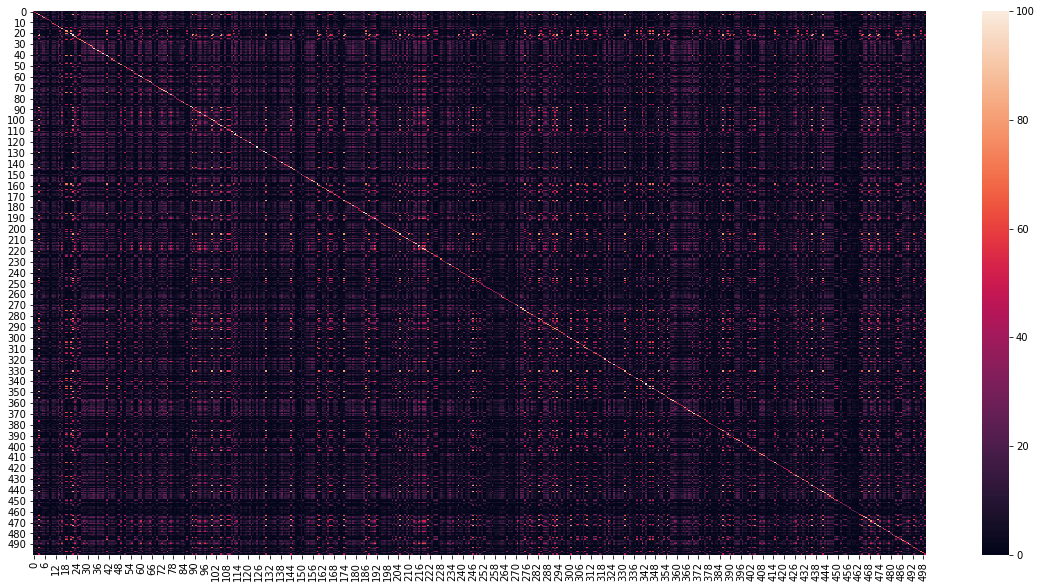

In [98]:
plt.figure(figsize=(20, 10))
sns.heatmap(ol)

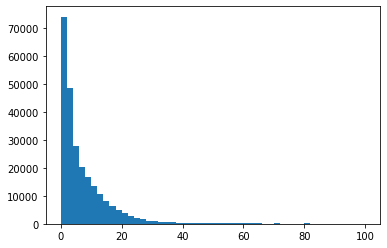

In [90]:
_ = plt.hist(ol.flatten(), bins=50)

In [91]:
np.unique(sequences._sampled_datasets, return_counts=True)

(array(['EA_negative', 'EA_positive', 'negative', 'positive'], dtype='<U11'),
 array([105, 242,  69,  84]))

In [96]:
np.sum(eq)

500.0